In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import descwl
import galsim

In [12]:
import os
import astropy.io.fits as fits
import astropy.table

In [3]:
output_catalog_path = '..'
def locate(name): return os.path.join(output_catalog_path,'%s.fits' % name)

In [8]:
LSST_r = fits.open(locate('LSST_r_june'))

In [9]:
def make_samples(cat,isolation_cut,detection_cut,verbose=True):
    # Only use sources with centroids within the area and snr_iso > 0.
    bad_snr = (cat['snr_iso']<=0.)
    num_bad = np.count_nonzero(bad_snr)
    if (num_bad > 0) and verbose:
        print 'Dropped %d sources with snr_iso = 0 (max. snr_sky = %.3f)' % (
            num_bad,np.max(cat['snr_sky'][bad_snr]))
    #visible = np.logical_and(np.logical_not(bad_snr),cat['visible']>0)
    star = (cat['db_id']<10000000)
    #print 'Dropped %d sources with snr_iso = 0 (max. snr_sky = %.3f)' % (
    #    np.count_nonzero(bad_snr),np.max(cat['snr_sky'][bad_snr]))
    if verbose:
        print 'Stellar sources simulated %d' % (np.count_nonzero(star))
    gal = np.logical_not(star)
    big_emag = np.logical_or(np.absolute(cat['e1'])>10,np.absolute(cat['e2'])>10)
    emag = np.sqrt(cat['e1']**2+cat['e2']**2)
    no_emag = np.logical_or(np.isnan(emag),big_emag)
    gal2 = np.logical_and(gal,np.logical_not(no_emag))
    vis_aux = np.logical_and(cat['visible']>0,gal2)
    if verbose:
        print 'Number of galaxies %d' % (np.count_nonzero(gal2))
    visible = np.logical_and(np.logical_not(bad_snr),vis_aux)
    num_visible = np.count_nonzero(visible)
    # Undetected sources are visible but fail the detection cut.
    undetected = np.logical_and(visible,cat['snr_grpf']<detection_cut)
    num_undetected = np.count_nonzero(undetected)
    detected = np.logical_and(visible,cat['snr_grpf']>=detection_cut)
    num_detected = np.count_nonzero(detected)
    # Blended sources are visible, detected, and fail the purity cut.
    blended = np.logical_and(detected,cat['purity']<isolation_cut)
    num_blended = np.count_nonzero(blended)
    # Isolated sources are visible, detected, and pass the purity cut.
    isolated = np.logical_and(detected,cat['purity']>=isolation_cut)
    num_isolated = np.count_nonzero(isolated)
    # Print summary statistics.
    if verbose:
        print 'Visible sample fractions: undetected %.2f%%, blended %.2f%%, isolated %.2f%%' % (
            100.*num_undetected/num_visible,100.*num_blended/num_visible,100.*num_isolated/num_visible)
        print 'Detected sample fractions: blended %.2f%%, isolated %.2f%%' % (
            100.*num_blended/num_detected,100.*num_isolated/num_detected)
    return undetected,detected,blended,isolated

In [52]:
def z_plot(results,match=None,isolation_cut=0.98,detection_cut=6.,save=None,correct_rpsf=True, fix_sigma_i=False):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    # Get our filter band.
    filter = hdr['FILTER_BAND'[-8:]].rstrip()
    # Calculate the simulated area in sq.arcmins.
    area = hdr['IMAGE_WIDTH'[-8:]]*hdr['IMAGE_HEIGHT'[-8:]]*hdr['PIXEL_SCALE'[-8:]]**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    # Only use sources with centroids within the area and snr_iso > 0.
    bad_snr = (cat['snr_iso']<=0.)
    # Get our samples.
    if match!=None:
        detected2,matched2,indices2,distance2 = match
        print 1.0*np.count_nonzero(matched2)/len(matched2)
    undetected,detected,blended,isolated = make_samples(cat,isolation_cut,detection_cut)
    # Calculate the intrinsic shape noise variance of detected objects.
    intrinsic_var = 0.5*(np.var(cat['e1'][detected]) + np.var(cat['e2'][detected]))
    print 'Detected intrinsic shape-noise RMS = %.3f' % np.sqrt(intrinsic_var)
    # Calculate neff weights per object.
    wgt = 0.5*(intrinsic_var/(intrinsic_var+cat['dg1_grp']**2)+intrinsic_var/(intrinsic_var+cat['dg2_grp']**2))
    # Calculate |e| values per object.
    emag = np.sqrt(cat['e1']**2+cat['e2']**2)
    # Summary statistics.
    num_detected = np.count_nonzero(detected)
    for name in ('detected','isolated','blended'):
        sample = eval(name)
        num_sample = np.count_nonzero(sample)
        Neff = np.sum(wgt[sample])/area
        var_e = 0.5*(np.nanvar(cat['e1'][sample])+np.nanvar(cat['e2'][sample]))
        zavg = np.sum(wgt[sample]*cat['z'][sample])/np.sum(wgt[sample])
        print '%10s sample is %5.1f%% of detected with neff/area = %6.3f, RMS e = %6.4f, <z> = %.3f, <n> = %.3f' % (
            name,100.*num_sample/num_detected,Neff,np.sqrt(var_e),zavg,num_sample/area)
    # Calculate sigma_i,12 and the pessimistic, fiducial and optimistic scenarios
    sm12 = np.sqrt(0.5*cat['dg1_grp']**2+0.5*cat['dg2_grp']**2)
    sm = np.sqrt((cat['dg1_grp']**2*cat['dg2_grp']**2+intrinsic_var*sm12**2)/(intrinsic_var+sm12**2))
    pes = sm < 0.5*np.sqrt(intrinsic_var)
    fid = sm < np.sqrt(intrinsic_var)
    op = sm < 2.*np.sqrt(intrinsic_var)
    # Calculate R to compare with Chang et al. 2013
    r_psf = hdr['PSF_SIGP']
    if correct_rpsf:
        r_psf = r_psf/(2.*np.sqrt(2*np.log(2)))
    R = cat['sigma_p']**2/r_psf**2
    # Use the value from the catalog or fix it to match Chang et al. 2013
    if fix_sigma_i:
        intrinsic_var=0.26**2
    # Formula of Bernstein and Jain 2002 with coefficients from Chang et al. 2013
    a= 1.58
    b = 5.03
    c = 0.39
    sm_chang = a/cat['snr_iso']*(1+(b/R)**c)
    pes2 = sm_chang < 0.5*np.sqrt(intrinsic_var)
    fid2 = sm_chang < np.sqrt(intrinsic_var)
    op2 = sm_chang < 2.*np.sqrt(intrinsic_var)
    wgt_c = intrinsic_var/(intrinsic_var+sm_chang**2)
    zbins=np.arange(0,4,0.25)
    zcent = zbins[1:]+zbins[:-1]
    zcent = zcent*0.5
    neff_op_c = np.zeros(len(zbins)-1)
    neff_fid_c = np.zeros_like(neff_op_c)
    neff_pes_c = np.zeros_like(neff_op_c)
    neff_op = np.zeros(len(zbins)-1)
    neff_fid = np.zeros_like(neff_op_c)
    neff_pes = np.zeros_like(neff_op_c)
    neff_wld = np.zeros_like(neff_op_c)
    for ii in range(0,len(zbins)-1):
        pes_aux = pes2 & (cat['z']>=zbins[ii]) & (cat['z']<zbins[ii+1])
        fid_aux = fid2 & (cat['z']>=zbins[ii]) & (cat['z']<zbins[ii+1])
        op_aux = op2 & (cat['z']>=zbins[ii]) & (cat['z']<zbins[ii+1])
        neff_pes_c[ii]=np.sum(wgt_c[pes_aux])/area
        neff_fid_c[ii]=np.sum(wgt_c[fid_aux])/area
        neff_op_c[ii]=np.sum(wgt_c[op_aux])/area
        pes_aux = pes & (cat['z']>=zbins[ii]) & (cat['z']<zbins[ii+1])
        fid_aux = fid & (cat['z']>=zbins[ii]) & (cat['z']<zbins[ii+1])
        op_aux = op & (cat['z']>=zbins[ii]) & (cat['z']<zbins[ii+1])
        neff_pes[ii]=np.sum(wgt[pes_aux])/area
        neff_fid[ii]=np.sum(wgt[fid_aux])/area
        neff_op[ii]=np.sum(wgt[op_aux])/area
        neff_wld[ii]=np.sum(wgt[detected & (cat['z']>=zbins[ii]) & (cat['z']<zbins[ii+1])])/area
    plt.figure()
    plt.plot(zcent,neff_pes_c,'o-',label='Pesimistic BJ')
    plt.plot(zcent,neff_fid_c,'o-',label='Fiducial BJ')
    plt.plot(zcent,neff_op_c,'o-',label='Optimistic BJ')
    plt.plot(zcent,neff_pes,'^--',label='Pesimistic WLD')
    plt.plot(zcent,neff_fid,'^--',label='Fiducial WLD')
    plt.plot(zcent,neff_op,'^--',label='Optimistic WLD')
    plt.plot(zcent,neff_wld,'o-',label='Using SNR weights')
    plt.xlabel('$z$')
    plt.ylabel('$n_{eff}$')
    plt.grid()
    plt.legend(loc='best')

Simulated area = 186.414 sq.arcmins.
Dropped 13 sources with snr_iso = 0 (max. snr_sky = 0.128)
Stellar sources simulated 0
Number of galaxies 45315
Visible sample fractions: undetected 73.15%, blended 10.17%, isolated 16.68%
Detected sample fractions: blended 37.88%, isolated 62.12%
Detected intrinsic shape-noise RMS = 0.243
  detected sample is 100.0% of detected with neff/area = 40.456, RMS e = 0.2434, <z> = 1.177, <n> = 64.813
  isolated sample is  62.1% of detected with neff/area = 24.867, RMS e = 0.2476, <z> = 1.146, <n> = 40.260
   blended sample is  37.9% of detected with neff/area = 15.589, RMS e = 0.2365, <z> = 1.228, <n> = 24.553


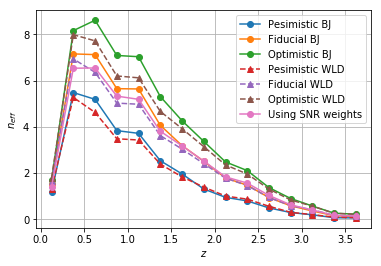

In [53]:
z_plot(LSST_r)